In [0]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

In [0]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
df = pd.read_csv('BTCUSDTEST.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [27]:
df.sample(5)

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2017-01-07,BTCUSD,893.49,908.10,820.99,898.75,2263.37,1969093.18
2018-09-22,BTCUSD,6759.51,6818.23,6630.00,6710.26,884.13,5939670.74
2019-02-13,BTCUSD,3588.61,3627.79,3561.22,3576.48,1831.34,6560232.65
2017-08-22,BTCUSD,3993.87,4140.05,3600.01,4093.28,17464.11,68475115.16
2019-04-08,BTCUSD,5196.02,5350.00,5132.26,5287.88,2766.25,14524197.92


In [0]:
# Extract the bitcoin data only
btc=df[df['Symbol']=='BTCUSD']
# Drop some columns
btc.drop(['Volume', 'Market Cap'],axis=1,inplace=True) 

In [0]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.446965


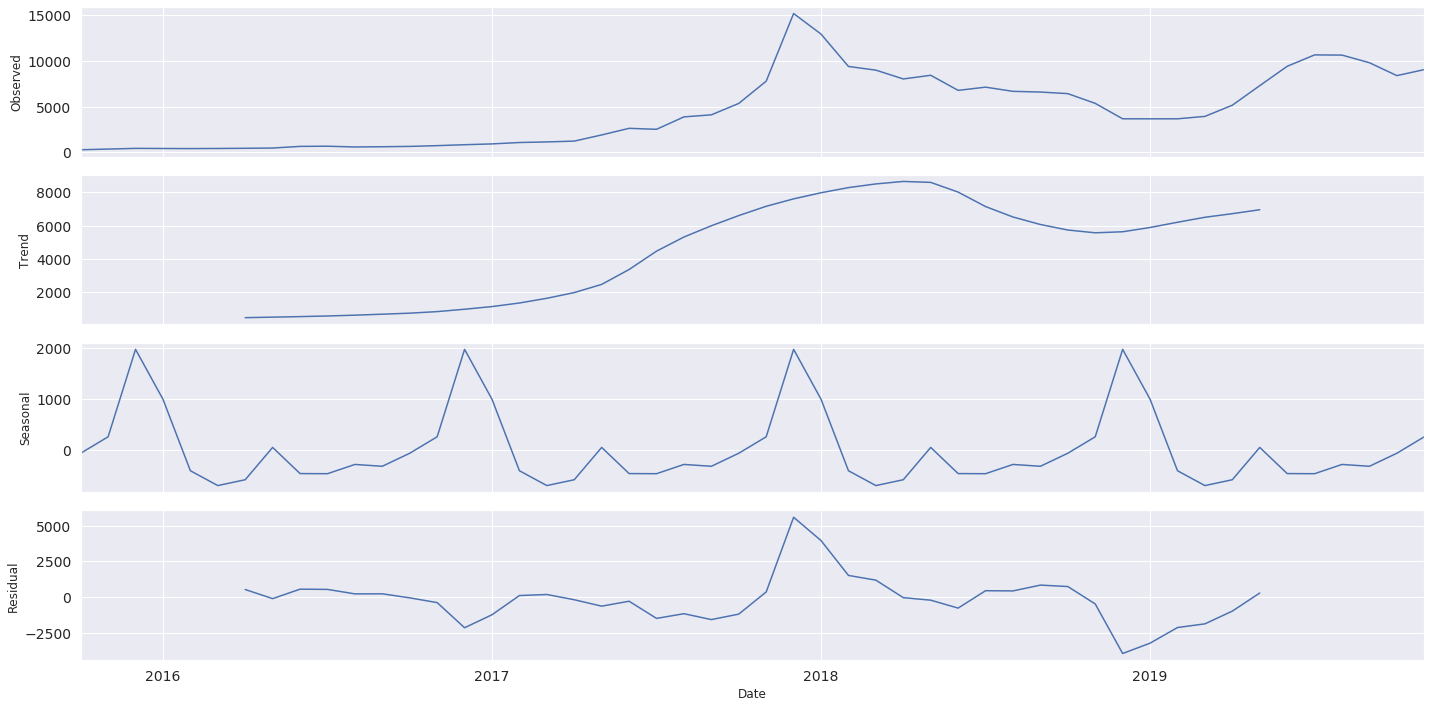

In [30]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])

In [31]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.655145


In [32]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.486299


In [33]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.113594


Dickey–Fuller test: p=0.001415


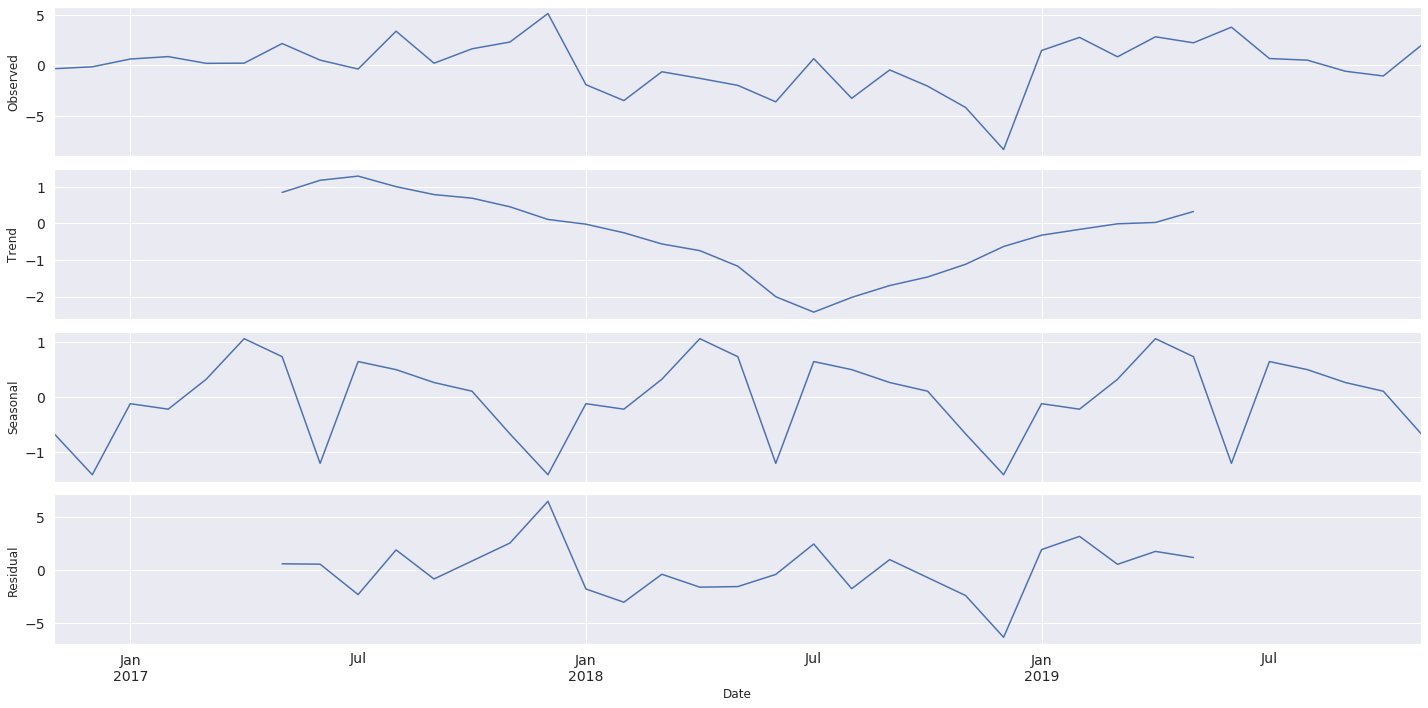

In [34]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

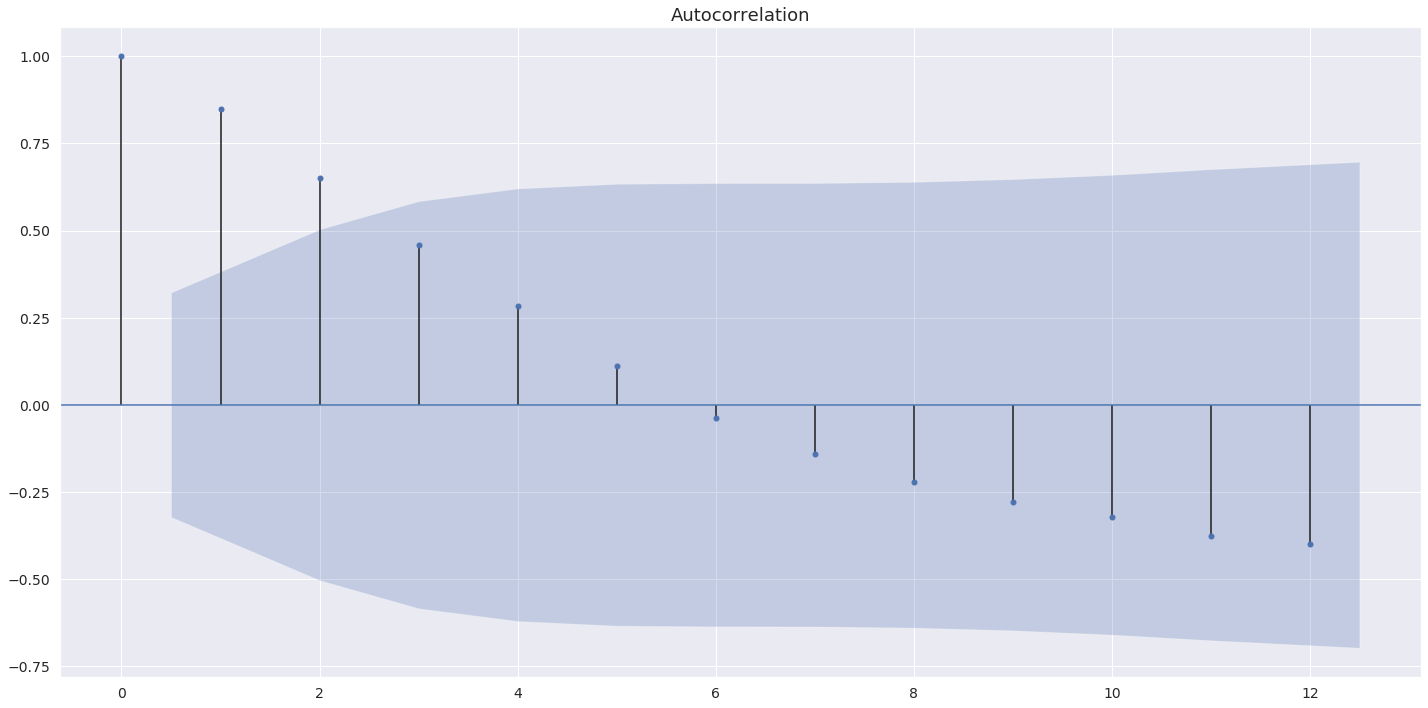

In [35]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()

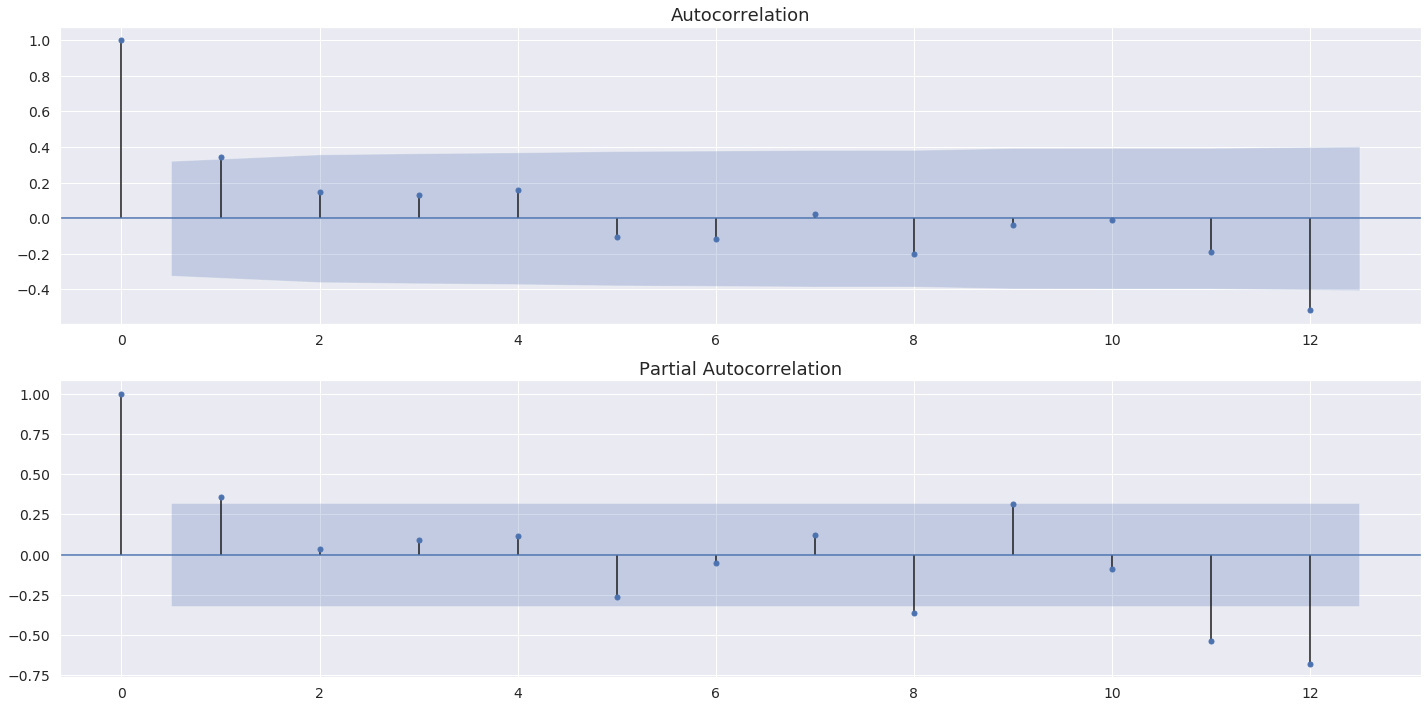

In [36]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

In [0]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [38]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0)  174.098321
1     (0, 1)  175.167060
4     (1, 1)  176.097944
6     (2, 0)  176.097967
2     (0, 2)  176.153721


In [39]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   50
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -85.049
Date:                Wed, 20 Nov 2019   AIC                            174.098
Time:                        08:52:08   BIC                            177.882
Sample:                    10-31-2015   HQIC                           175.534
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3886      0.071      5.490      0.000       0.250       0.527
sigma2         1.8779      0.271      6.938      0.000       1.347       2.408
Ljung-Box (Q):                       21.45   Jarque-

In [40]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


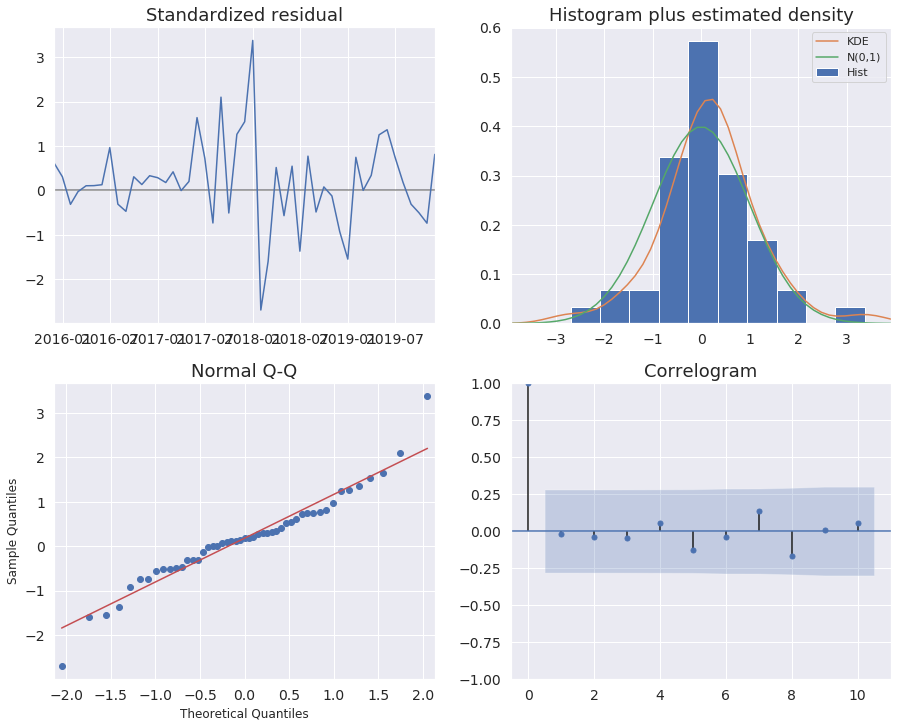

In [41]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [0]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Text(0, 0.5, 'USD')

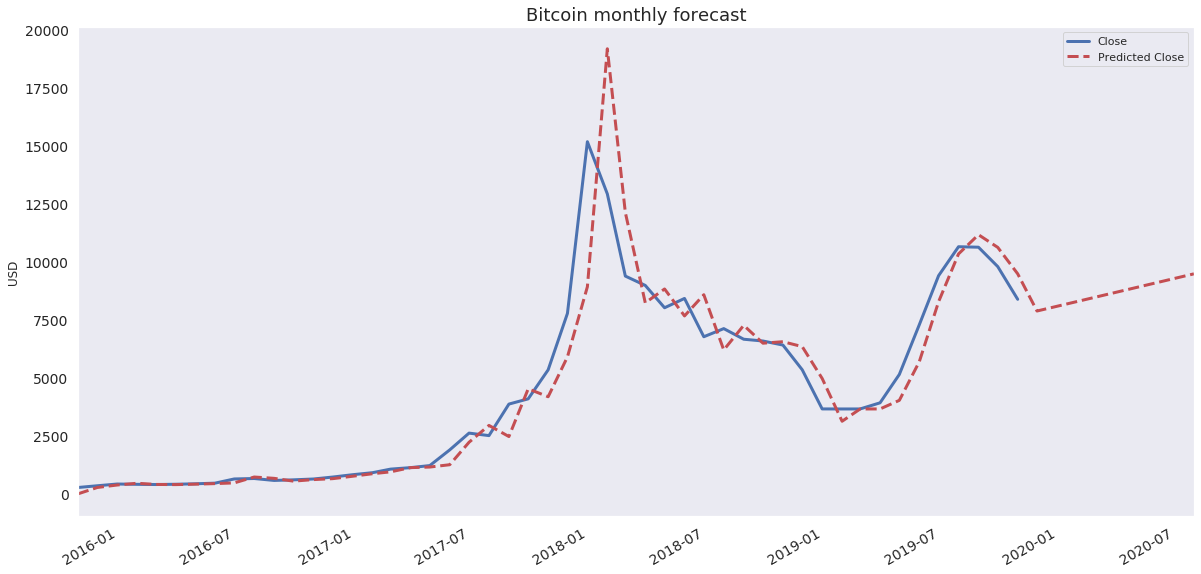

In [55]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2019, 10, 31), datetime(2019, 11, 30), datetime(2020, 7, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2015, 10, 31), end=datetime(2020, 7, 31)), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')

In [0]:
#from google.colab import files
#uploaded = files.upload()